In [1]:
import mlflow
import pickle
import sys
sys.path.insert(1, '../library')
import database_helper
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

2024-08-31 15:32:14.127750: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-31 15:32:14.128123: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-31 15:32:14.129999: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-31 15:32:14.135198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-31 15:32:14.143818: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
os.environ["MLFLOW_TRACKING_USERNAME"] = "user"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "password"
mlflow.set_tracking_uri(uri="http://mlflow.local:80")
mlflow.set_experiment("Multi-Output Time Series Forecast")
mlflow.autolog()

2024/08/31 15:32:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/08/31 15:32:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/08/31 15:32:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


In [3]:
with open('selected_columns.pkl', 'rb') as f:
    selected_columns = pickle.load(f)
df = database_helper.query_data(field_list=selected_columns)

Executing Query 1 (Maximum 5 days)
Executing Query 2 (Maximum 5 days)
Executing Query 3 (Maximum 5 days)
Executing Query 4 (Maximum 5 days)
Executing Query 5 (Maximum 5 days)
Executing Query 6 (Maximum 5 days)
Executing Query 7 (Maximum 5 days)


In [4]:
date_time = pd.to_datetime(df.pop('_time'), format='%d.%m.%Y %H:%M:%S')
df = df.select_dtypes(include='float64')
df.interpolate(inplace=True)
display(df)
display(date_time)

,10838_days_0_precipitation,10838_days_0_temperatureMax,10838_days_0_windDirection,10838_days_1_sunshine,10838_days_1_temperatureMin,10838_days_1_windDirection,10838_days_2_precipitation,10838_days_2_sunshine,10838_days_2_temperatureMax,10838_days_2_temperatureMin,...,10840_days_7_windDirection,10840_days_8_sunshine,10840_days_8_temperatureMax,10840_days_8_temperatureMin,10840_days_8_windDirection,10840_days_8_windGust,10840_days_9_precipitation,10840_days_9_sunshine,10840_days_9_temperatureMax,10840_days_9_windDirection
0,59.0,229.0,3210.0,8200.0,119.0,720.0,0.0,7590.0,303.0,123.0,...,2580.0,4360.0,236.0,151.0,2470.0,315.0,0.0,4280.0,246.0,2380.0
1,59.0,229.0,3210.0,8200.0,119.0,720.0,0.0,7590.0,303.0,123.0,...,2580.0,4360.0,236.0,151.0,2470.0,315.0,0.0,4280.0,246.0,2380.0
2,59.0,229.0,3210.0,8200.0,119.0,720.0,0.0,7590.0,303.0,123.0,...,2580.0,4360.0,236.0,151.0,2470.0,315.0,0.0,4280.0,246.0,2380.0
3,59.0,229.0,3210.0,8200.0,119.0,720.0,0.0,7590.0,303.0,123.0,...,2580.0,4360.0,236.0,151.0,2470.0,315.0,0.0,4280.0,246.0,2380.0
4,59.0,229.0,3210.0,8200.0,119.0,720.0,0.0,7590.0,303.0,123.0,...,2580.0,4360.0,236.0,151.0,2470.0,315.0,0.0,4280.0,246.0,2380.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43186,17.0,232.0,2770.0,2610.0,163.0,2520.0,0.0,2950.0,230.0,157.0,...,2170.0,5530.0,255.0,156.0,1990.0,278.0,0.0,5190.0,252.0,3310.0
43187,17.0,232.0,2770.0,2610.0,163.0,2520.0,0.0,2950.0,230.0,157.0,...,2170.0,5530.0,255.0,156.0,1990.0,278.0,0.0,5190.0,252.0,3310.0
43188,17.0,232.0,2770.0,2610.0,163.0,2520.0,0.0,2950.0,230.0,157.0,...,2170.0,5530.0,255.0,156.0,1990.0,278.0,0.0,5190.0,252.0,3310.0
43189,17.0,232.0,2770.0,2610.0,163.0,2520.0,0.0,2950.0,230.0,157.0,...,2170.0,5530.0,255.0,156.0,1990.0,278.0,0.0,5190.0,252.0,3310.0


0       2024-07-28 12:00:00+00:00
1       2024-07-28 12:00:10+00:00
2       2024-07-28 12:00:20+00:00
3       2024-07-28 12:00:30+00:00
4       2024-07-28 12:00:40+00:00
                   ...           
43186   2024-08-02 11:59:10+00:00
43187   2024-08-02 11:59:20+00:00
43188   2024-08-02 11:59:30+00:00
43189   2024-08-02 11:59:40+00:00
43190   2024-08-02 11:59:50+00:00
Name: _time, Length: 43191, dtype: datetime64[ns, UTC]

Text(0.5, 1.0, 'Time of day signal')

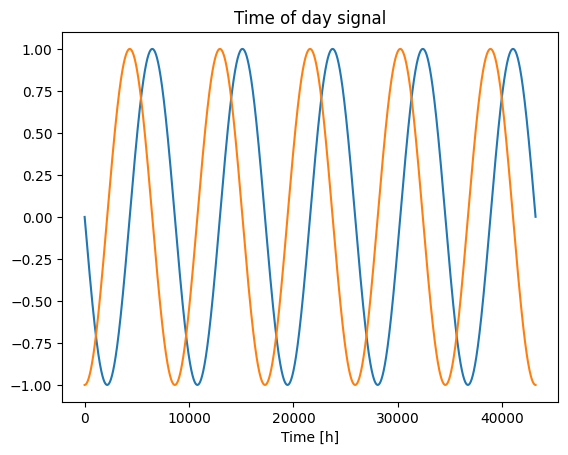

In [5]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
plt.plot(np.array(df['Day sin'])[:])
plt.plot(np.array(df['Day cos'])[:])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [6]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [7]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [8]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [9]:
w2 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['10838_days_1_sunshine'])
w2

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['10838_days_1_sunshine']

In [10]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [11]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 48, 100)
Inputs shape: (3, 24, 100)
Labels shape: (3, 1, 1)


In [12]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [13]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [14]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 100)
Labels shape (batch, time, features): (32, 1, 1)


2024-08-31 15:33:14.881747: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 24, 100)
Labels shape (batch, time, features): (32, 24, 100)


2024-08-31 15:33:14.945009: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [16]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [21]:
val_performance = {}
performance = {}


In [22]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

#IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
print()


2024/08/31 15:41:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e44ab06cf42d459e88c50f0d8af66b40', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow
2024-08-31 15:41:16.600807: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.3592e-04 - mean_absolute_error: 0.0013 - val_loss: 0.0020 - val_mean_absolute_error: 0.0021
Epoch 2/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.4792e-04 - mean_absolute_error: 9.5669e-04 - val_loss: 0.0020 - val_mean_absolute_error: 0.0026
Epoch 3/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.4307e-04 - mean_absolute_error: 9.3877e-04 - val_loss: 0.0020 - val_mean_absolute_error: 0.0027


2024/08/31 15:41:26 WARNING mlflow.keras.autologging: Failed to get model signature, reason: 'ResidualWrapper' object has no attribute 'input_shape'
2024/08/31 15:41:26 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/08/31 15:41:28 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpjrq402v9/model, flavor: keras). Fall back to return ['keras==3.4.1']. Set logging level to DEBUG to see the full traceback. 
2024/08/31 15:41:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/31 15:41:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run powerful-bee-782 at: http://mlflow.local:80/#/experiments/4/runs/e44ab06cf42d459e88c50f0d8af66b40.
2024/08/31 15:41:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.local:80/#/experiments/4.

270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - mean_absolute_error: 0.0026

CPU times: user 31.2 s, sys: 3.96 s, total: 35.2 s
Wall time: 16.7 s
